In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, iirnotch, lfilter, sosfilt, sosfreqz, filtfilt, sosfiltfilt
import biosppy
from biosppy.signals import ecg
import matplotlib.gridspec as gridspec

In [2]:
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
def butter_bandpass(lowcut, highcut, fs=100, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    return sos


def notch(cutoff, q):
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs=100, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y


def notch_filter(data, powerline, q):
    b, a = notch(powerline, q)
    z = lfilter(b, a, data)
    return z

In [4]:
def butter_highpass(cutoff, sample_rate, order, data):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    final_filtered_highpass = filtfilt(b, a, data)
    return final_filtered_highpass


def butter_lowpass(cutoff, sample_rate, order, data, slice=-1):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_lowpass = lfilter(b, a, data)
    return filtered_lowpass


def moving_average_filter(x, w):
    m_a_filtered = np.convolve(x, np.ones(w), 'same') / w
    return m_a_filtered


def filter_data(data, sample_rate=100):
    low_pass_filtering = butter_lowpass(41, sample_rate, 5, data)
    high_pass_filtering = butter_highpass(0.5, sample_rate, 2, low_pass_filtering)
    #m_a_filtered = moving_average_filter(high_pass_filtering, 3)
    return high_pass_filtering


def plot_signals_for_comparison(original_signal, filtered_signal):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.set_title('Raw ECG')
    ax1.plot(original_signal)
    ax1.grid()
    ax2.set_title('Filtered ECG [0.5Hz - 49Hz]')
    ax2.plot(filtered_signal)
    ax2.set_xlabel('Time [100 miliseconds]')
    ax2.grid()
    plt.tight_layout()
    plt.show()

In [5]:
def correct_rpeaks(signal, rpeaks=None, sampling_rate=100, tol=0.05):
    """Correct R-peak locations to the maximum within a tolerance.
    Parameters
    ----------
    signal : array
        ECG signal.
    rpeaks : array
        R-peak location indices.
    sampling_rate : int, float, optional
        Sampling frequency (Hz).
    tol : int, float, optional
        Correction tolerance (seconds).
    Returns
    -------
    rpeaks : array
        Cerrected R-peak location indices.
    Notes
    -----
    * The tolerance is defined as the time interval :math:`[R-tol, R+tol[`.
    """

    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    if rpeaks is None:
        raise TypeError("Please specify the input R-peaks.")

    tol = int(tol * sampling_rate)
    length = len(signal)

    newR = []
    for r in rpeaks:
        a = r - tol
        if a < 0:
            continue
        b = r + tol
        if b > length:
            break
        newR.append(a + np.argmax(signal[a:b]))

    newR = sorted(list(set(newR)))
    newR = np.array(newR, dtype='int')

    return newR

In [6]:
def _extract_heartbeats(signal=None, rpeaks=None, before=200, after=400):
    """Extract heartbeat templates from an ECG signal, given a list of
    R-peak locations.
    Parameters
    ----------
    signal : array
        Input ECG signal.
    rpeaks : array
        R-peak location indices.
    before : int, optional
        Number of samples to include before the R peak.
    after : int, optional
        Number of samples to include after the R peak.
    Returns
    -------
    templates : array
        Extracted heartbeat templates.
    rpeaks : array
        Corresponding R-peak location indices of the extracted heartbeat
        templates.
    """

    R = np.sort(rpeaks)
    length = len(signal)
    templates = []
    newR = []

    for r in R:
        a = r - before
        if a < 0:
            continue
        b = r + after
        if b > length:
            break
        templates.append(signal[a:b])
        newR.append(r)

    templates = np.array(templates)
    newR = np.array(newR, dtype='int')

    return templates, newR

In [7]:
def extract_heartbeats(signal=None, rpeaks=None, sampling_rate=1000.,
                       before=0.2, after=0.4):
    """Extract heartbeat templates from an ECG signal, given a list of
    R-peak locations.
    Parameters
    ----------
    signal : array
        Input ECG signal.
    rpeaks : array
        R-peak location indices.
    sampling_rate : int, float, optional
        Sampling frequency (Hz).
    before : float, optional
        Window size to include before the R peak (seconds).
    after : int, optional
        Window size to include after the R peak (seconds).
    Returns
    -------
    templates : array
        Extracted heartbeat templates.
    rpeaks : array
        Corresponding R-peak location indices of the extracted heartbeat
        templates.
    """

    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    if rpeaks is None:
        raise TypeError("Please specify the input R-peak locations.")

    if before < 0:
        raise ValueError("Please specify a non-negative 'before' value.")
    if after < 0:
        raise ValueError("Please specify a non-negative 'after' value.")

    # convert delimiters to samples
    before = int(before * sampling_rate)
    after = int(after * sampling_rate)

    # get heartbeats
    templates, newR = _extract_heartbeats(signal=signal,
                                          rpeaks=rpeaks,
                                          before=before,
                                          after=after)

    return templates, newR

In [8]:
def get_complete_Heartbit(sample, sampling_rate=100,plot=True):
    filtered_sample = filter_data(sample,sampling_rate)
    data = filtered_sample.T
    signals = []
    indices = []
    count = 1
    peaks = biosppy.signals.ecg.christov_segmenter(
        signal=data, sampling_rate=sampling_rate)[0]
    rpeaks = correct_rpeaks(signal=data,rpeaks=peaks, sampling_rate=100,tol=0.05)
    templates, rpeaks = extract_heartbeats(signal=data,rpeaks=rpeaks,sampling_rate=100,before=0.2,after=0.4)
    if plot:
        ts_tmpl = np.linspace(-0.2, 0.4, templates.shape[1], endpoint=False)
        fig = plt.figure()
        gs = gridspec.GridSpec(6, 2)
        ax4 = fig.add_subplot(gs[1:5, 1])
        plt.plot(ts_tmpl, templates.T, 'm', linewidth=1.5, alpha=0.7)
        ax4.set_xlabel('Time (s)')
        ax4.set_ylabel('Amplitude')
        ax4.set_title('Templates')
        ax4.grid()
    #return templates, rpeaks
    return templates

In [9]:
df = pd.read_csv("ECG_Rhythm_Lead_I.csv")
df.shape

(21837, 1007)

In [10]:
df

,Unnamed: 0,ecg_id,age,sex,height,weight,rhythm_diag,0,1,2,...,990,991,992,993,994,995,996,997,998,999
0,0,1,56.0,1,NaN,63.0,SR,-0.119,-0.116,-0.120,...,0.198,0.194,0.115,0.107,0.107,0.106,0.090,0.069,0.086,0.022
1,1,2,19.0,0,NaN,70.0,OTHER,0.004,-0.020,-0.053,...,-0.035,-0.045,0.004,0.044,0.507,0.554,0.316,0.121,-0.326,-0.348
2,2,3,37.0,1,NaN,69.0,SR,-0.029,-0.035,-0.054,...,-0.040,-0.051,-0.026,-0.032,-0.052,-0.039,-0.034,-0.029,-0.048,-0.049
3,3,4,24.0,0,NaN,82.0,SR,-0.054,-0.053,-0.063,...,-0.312,-0.511,-0.280,-0.076,-0.012,0.001,-0.003,0.026,0.026,0.028
4,4,5,19.0,1,NaN,70.0,SR,-0.034,-0.038,-0.057,...,0.005,0.001,0.003,0.013,0.018,-0.001,0.007,0.000,-0.003,-0.012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21832,21832,21833,67.0,1,NaN,NaN,OTHER,-0.052,-0.077,-0.042,...,-0.143,-0.125,-0.104,-0.097,-0.052,0.010,0.019,-0.024,-0.061,-0.050
21833,21833,21834,93.0,0,NaN,NaN,SR,-0.050,-0.032,0.008,...,-0.023,-0.052,-0.062,-0.059,-0.074,-0.069,-0.107,0.058,0.501,0.584
21834,21834,21835,59.0,1,NaN,NaN,SR,0.038,0.078,-0.014,...,-0.081,0.012,0.504,0.613,0.328,0.061,0.037,-0.106,-0.045,0.463
21835,21835,21836,64.0,1,NaN,NaN,SR,-0.057,-0.041,0.003,...,0.074,0.112,0.116,0.115,0.112,0.096,0.051,0.033,0.027,-0.006


In [11]:
del df["Unnamed: 0"]
df = df.loc[df.rhythm_diag != 'OTHER']

In [13]:
df.rhythm_diag.value_counts()
df.replace({'rhythm_diag': {'SR': 0, 'AFIB': 1}}, inplace=True)
df.rhythm_diag.value_counts()

0    16782
1     1514
Name: rhythm_diag, dtype: int64

In [14]:
from sklearn.utils import resample
df_minority = df[df['rhythm_diag']==1]
df_majority = df[df['rhythm_diag']==0]
maj_class = resample(df_majority,
                     replace=True,
                     n_samples=1514,
                     random_state=123)
df=pd.concat([df_minority,maj_class])

In [15]:
df

,ecg_id,age,sex,height,weight,rhythm_diag,0,1,2,3,...,990,991,992,993,994,995,996,997,998,999
16,17,56.0,0,NaN,NaN,1,-0.041,-0.025,0.041,0.036,...,-0.074,-0.054,-0.036,-0.027,0.020,0.028,0.055,0.063,0.058,0.079
151,152,70.0,1,NaN,NaN,1,-0.008,-0.029,-0.026,-0.006,...,0.067,0.055,0.037,0.038,0.060,0.084,0.113,0.097,0.076,0.058
281,282,91.0,0,175.0,NaN,1,-0.262,-0.285,-0.293,-0.271,...,-0.160,-0.173,-0.238,-0.268,-0.270,-0.238,-0.204,-0.230,-0.247,-0.214
306,307,63.0,0,174.0,64.0,1,-0.043,-0.056,-0.071,-0.105,...,-0.010,-0.021,-0.013,-0.018,-0.010,-0.014,-0.010,-0.064,-0.128,-0.144
317,318,56.0,0,163.0,94.0,1,-0.199,-0.115,0.145,0.372,...,0.040,0.062,0.082,0.116,0.112,0.115,0.112,0.112,0.074,0.077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16495,16496,67.0,1,NaN,NaN,0,-0.060,-0.057,-0.049,-0.043,...,-0.043,-0.039,-0.031,0.020,0.007,-0.062,-0.078,-0.078,-0.078,-0.049
15682,15683,73.0,1,157.0,37.0,0,0.004,0.014,0.043,0.045,...,0.043,0.034,0.036,0.035,0.036,0.041,0.043,0.050,0.051,0.057
9062,9063,41.0,1,NaN,76.0,0,0.200,0.197,0.186,0.181,...,-0.088,-0.133,-0.126,-0.071,-0.048,-0.039,-0.009,-0.034,-0.040,0.031
7970,7971,85.0,0,NaN,NaN,0,-0.566,-0.578,-0.612,-0.400,...,0.363,0.846,0.475,0.013,-0.074,-0.102,-0.109,-0.125,-0.138,-0.128


In [16]:
y = df.rhythm_diag.values

In [17]:
y.shape

(3028,)

In [18]:
df_sr = df[df.rhythm_diag == 0]
df_sr = df_sr.drop(['ecg_id', 'age', 'sex', 'height',
                    'weight', 'rhythm_diag'], axis=1)
df_sr.reset_index(drop= True ,inplace=True)
df_sr.shape

(1514, 1000)

In [19]:
df_afib = df[df.rhythm_diag == 1]
df_afib = df_afib.drop(['ecg_id', 'age', 'sex', 'height', 'weight', 'rhythm_diag'], axis=1)
df_afib.reset_index(drop= True ,inplace=True)
df_afib.shape

(1514, 1000)

In [20]:
X_sr = df_sr.values
X_afib = df_afib.values

In [21]:
templates_full_sr = []
templates_aux_sr = []
for i in range(len(X_sr)-1): 
    templates_aux_sr = get_complete_Heartbit(X_sr[i], 100,False)
    k = len(templates_full_sr);
    for j in range(len(templates_aux_sr)-1):
        templates_full_sr.append(templates_aux_sr[j])
templates_full_array_sr = np.array(templates_full_sr)

In [22]:
templates_full_array_sr.shape

(15368, 60)

In [23]:
templates_full_array_sr_labels = np.zeros(len(templates_full_array_sr))
templates_full_array_sr_labels.shape

(15368,)

In [24]:
templates_full_afib = []
templates_aux_afib = []
for i in range(len(X_afib)-1): 
    templates_aux_afib = get_complete_Heartbit(X_afib[i], 100,False)
    k = len(templates_full_afib);
    for j in range(len(templates_aux_afib)-1):
        templates_full_afib.append(templates_aux_afib[j])
templates_full_array_afib = np.array(templates_full_afib)

In [25]:
templates_full_array_afib.shape

(19039, 60)

In [26]:
templates_full_array_afib_labels = np.ones(len(templates_full_array_afib))
templates_full_array_afib_labels.shape

(19039,)

In [27]:
templates_full_array_labels = np.concatenate((templates_full_array_sr_labels, templates_full_array_afib_labels), axis=0)
templates_full_array_labels.shape

(34407,)

In [28]:
templates_full_array = np.concatenate((templates_full_array_sr, templates_full_array_afib), axis=0)
templates_full_array.shape

(34407, 60)

In [29]:
valorMaximo = templates_full_array.max()
valorMinimo = templates_full_array.min()
valorTotal = valorMaximo - (valorMinimo)
print(valorMaximo)
print(valorMinimo)
print(valorTotal)

2.51761992148376
-2.2229013259004193
4.740521247384179


#### Normalização

In [30]:
templates_full_array = templates_full_array - (valorMinimo)
valorMinimo = templates_full_array.min()
print(valorMinimo)

0.0


In [31]:
templates_full_array = templates_full_array/valorTotal
valorMaximo = templates_full_array.max()
valorMinimo = templates_full_array.min()
print(valorMaximo)
print(valorMinimo)

1.0
0.0


### Training

In [32]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(templates_full_array, templates_full_array_labels, test_size = 0.1)

In [33]:
from tensorflow.keras import Sequential,utils
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout
from sklearn.metrics import confusion_matrix, accuracy_score
import keras
import tensorflow as tf

In [34]:
xtrain.shape

(30966, 60)

In [35]:
model = Sequential()

model.add(Dense(units=30966, activation='relu', input_shape=(60, )))
#model.add(Dense(units=50,activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# For a binary classification problem
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30966)             1888926   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 30967     
Total params: 1,919,893
Trainable params: 1,919,893
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(xtrain,
                    ytrain,
                    epochs=20)

Epoch 1/20
968/968 [==============================] - 17s 17ms/step - loss: 0.6844 - accuracy: 0.5611
Epoch 2/20
968/968 [==============================] - 17s 18ms/step - loss: 0.6296 - accuracy: 0.6621
Epoch 3/20
968/968 [==============================] - 15s 15ms/step - loss: 0.5780 - accuracy: 0.7230
Epoch 4/20
968/968 [==============================] - 16s 16ms/step - loss: 0.5576 - accuracy: 0.7350
Epoch 5/20
968/968 [==============================] - 15s 16ms/step - loss: 0.5465 - accuracy: 0.74090s - loss: 0.5458 - accuracy - ETA: 0s - loss: 0.545
Epoch 6/20
968/968 [==============================] - 15s 16ms/step - loss: 0.5352 - accuracy: 0.75550s - loss: 0.5354 - accu
Epoch 7/20
968/968 [==============================] - 16s 16ms/step - loss: 0.5261 - accuracy: 0.7606
Epoch 8/20
968/968 [==============================] - 16s 17ms/step - loss: 0.5241 - accuracy: 0.7601
Epoch 9/20
968/968 [==============================] - 16s 17ms/step - loss: 0.5149 - accuracy: 0.7695
Epoch 

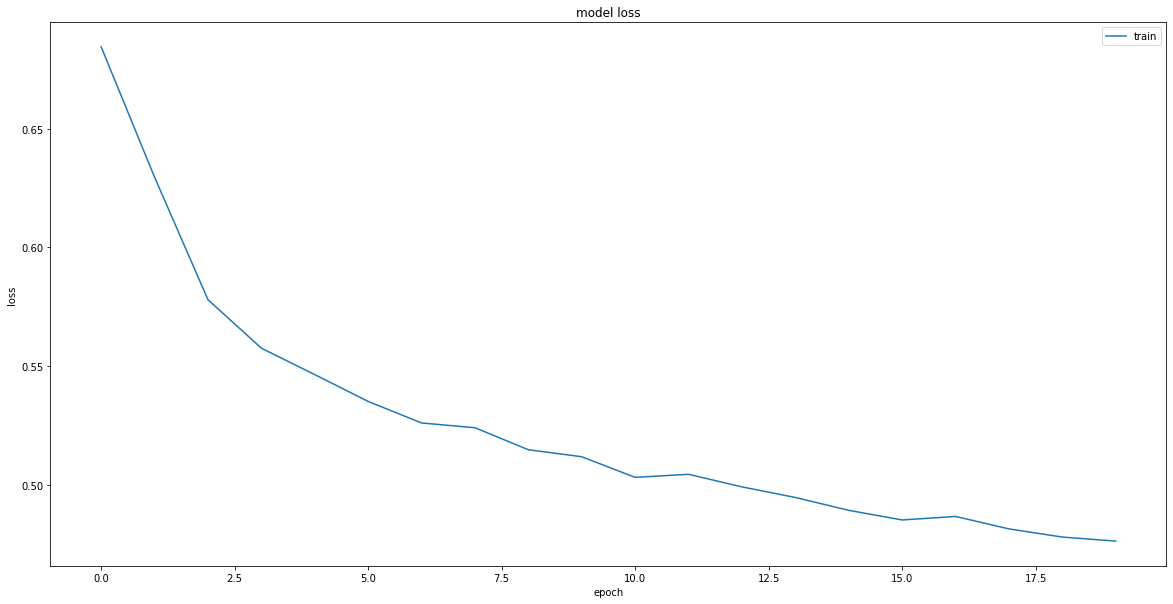

In [37]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

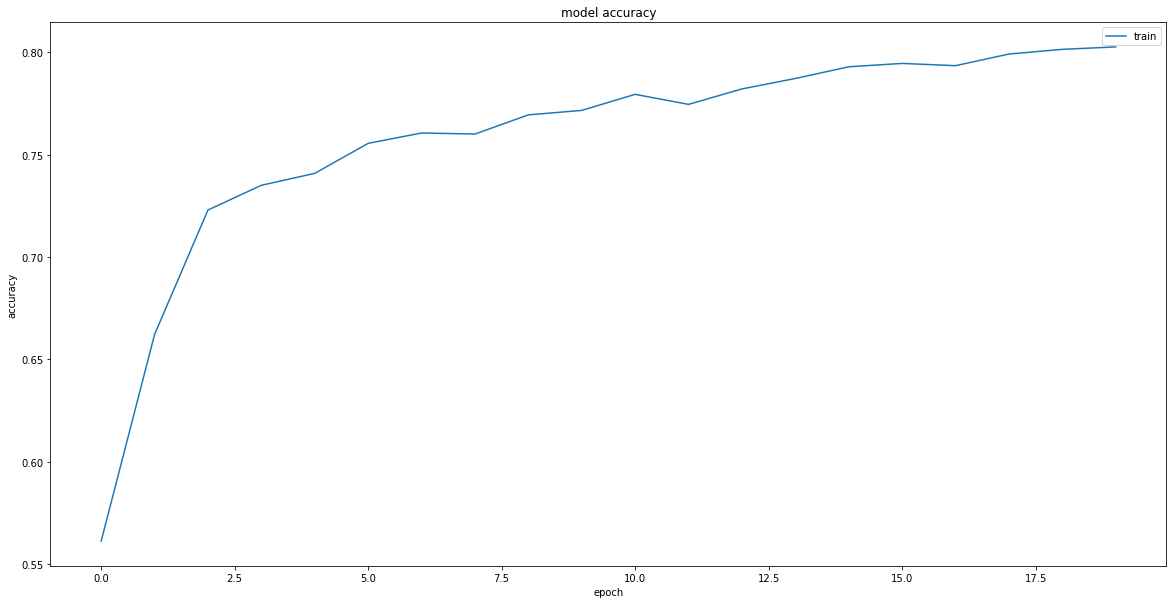

In [38]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [39]:
#evaluating the model
model.evaluate(xtest, ytest)

108/108 [==============================] - 1s 4ms/step - loss: 0.4837 - accuracy: 0.7954


[0.48367148637771606, 0.795408308506012]